In [6]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import pandas as pd
import glob
import os
from cftime import DatetimeNoLeap
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.collections import LineCollection
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
import matplotlib.patheffects as pe

import metpy
import metpy.calc as mpcalc
from metpy.units import units

#import geocat.datafiles as gdf  # Only for reading-in datasets
from xarray import open_mfdataset
import xarray as xr

from mpas_tools.database.utils import choose_forecast
from mpas_tools.plotting.utils import nonlinear_colorbar, basin_bboxes
from mpas_tools.utils.tools import find_TC_bbox
from mpas_tools.datashader_tools.utils import datashader_wrapper
from mpas_tools.utils.processing import saffir_simpson

# import holoviews as hv
# from holoviews import opts
# from holoviews.operation.datashader import rasterize as hds_rasterize

# import geoviews.feature as gf # only needed for coastlines
# from geoviews.operation import resample_geometry
# import geoviews as gv
# import geoviews.tile_sources as gts
# from datashader.mpl_ext import dsshow, alpha_colormap
# from bokeh.models import LinearColorMapper
# gv.extension("bokeh","matplotlib")

# opts.defaults(
#     opts.Image(width=1200, height=600),
#     opts.RGB(width=1200, height=600))

#hv.output(dpi=300, fig='png')

mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.titleweight'] = 'bold'

In [8]:
# New tracks for track_1279 (September 8th)
tracks_folder = r"/gpfs/group/cmz5202/default/cnd5285/MPAS_3km_config_opts"
tracks = glob.glob(os.path.join(tracks_folder, '*.nc'))
tracks.sort()
tracks

['/gpfs/group/cmz5202/default/cnd5285/MPAS_3km_config_opts/1279_x001.nc',
 '/gpfs/group/cmz5202/default/cnd5285/MPAS_3km_config_opts/1279_x002.nc',
 '/gpfs/group/cmz5202/default/cnd5285/MPAS_3km_config_opts/1279_x003.nc',
 '/gpfs/group/cmz5202/default/cnd5285/MPAS_3km_config_opts/1279_x004.nc',
 '/gpfs/group/cmz5202/default/cnd5285/MPAS_3km_config_opts/1279_x013.nc',
 '/gpfs/group/cmz5202/default/cnd5285/MPAS_3km_config_opts/1279_x014.nc',
 '/gpfs/group/cmz5202/default/cnd5285/MPAS_3km_config_opts/1279_x023.nc']

In [9]:
sims = [xr.open_dataset(t) for t in tracks]

In [41]:
sims[0]

<xarray.Dataset>
Dimensions:    (lat: 800, lon: 1000, nbnd: 2, time: 97)
Coordinates:
  * lat        (lat) float64 15.0 15.03 15.05 15.08 ... 34.92 34.95 34.97 35.0
  * lon        (lon) float64 271.0 271.0 271.1 271.1 ... 295.9 295.9 296.0 296.0
  * time       (time) object 2008-08-31 00:00:00 ... 2008-09-04 00:00:00
Dimensions without coordinates: nbnd
Data variables:
    lat_bnds   (lat, nbnd) float64 14.99 15.01 15.01 15.04 ... 34.99 34.99 35.01
    lon_bnds   (lon, nbnd) float64 ...
    gw         (lat) float64 ...
    area       (lat, lon) float64 ...
    FLUT       (time, lat, lon) float32 ...
    PRECT      (time, lat, lon) float32 ...
    PSL        (time, lat, lon) float32 1.015e+05 1.015e+05 ... 1.026e+05
    U10        (time, lat, lon) float32 ...
    UBOT       (time, lat, lon) float32 ...
    VBOT       (time, lat, lon) float32 ...
    time_bnds  (time, nbnd) object ...
Attributes: (12/17)
    Conventions:       CF-1.0
    source:            CAM
    case:              X2000-mp3a
    logname:           zarzycki
    host:              cheyenne4
    initial_file:      /glade/u/home/zarzycki/scratch/MPAS/3km_florida/x20.83...
    ...                ...
    remap_script:      ncremap
    remap_hostname:    cheyenne6
    remap_version:     5.0.3
    title:             Regridded version of cat.nc
    map_file:          /glade/u/home/zarzycki/scratch/map_mp3-15-florida_to_0...
    input_file:        /glade/u/home/zarzycki/scratch/X2000-mp3a/run/x001/cat.nc

In [32]:
for i, sim in enumerate(sims):
    max_wsp = sim.U10.values.max()
    tstep = sim.where(sim.U10 == max_wsp, drop=True)
    max_time = datetime.strptime(str(tstep.time.values[0]),'%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d %H:%M:%S')
    print(tracks[i].split('/')[-1])
    print(f"Max WSP: {round(max_wsp, 4)} m/s, {saffir_simpson(max_wsp, 'm/s')}, at {max_time}")
    print("")

1279_x001.nc
Max WSP: 54.69300079345703 m/s, Category 3, at 2008-09-01 11:00:00

1279_x002.nc
Max WSP: 54.97880172729492 m/s, Category 3, at 2008-09-01 09:00:00

1279_x003.nc
Max WSP: 54.01679992675781 m/s, Category 3, at 2008-09-02 06:00:00

1279_x004.nc
Max WSP: 54.35139846801758 m/s, Category 3, at 2008-09-01 11:00:00

1279_x013.nc
Max WSP: 57.178001403808594 m/s, Category 4, at 2008-09-01 17:00:00

1279_x014.nc
Max WSP: 54.15330123901367 m/s, Category 3, at 2008-08-31 22:00:00

1279_x023.nc
Max WSP: 57.03580093383789 m/s, Category 4, at 2008-09-01 14:00:00



In [33]:
# 2008-09-01 12:00:00	91920.81

for i, sim in enumerate(sims):
    min_slp = sim.PSL.values.min()
    tstep = sim.where(sim.PSL == min_slp, drop=True)
    min_time = datetime.strptime(str(tstep.time.values[0]),'%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d %H:%M:%S')
    print(tracks[i].split('/')[-1])
    print(f"Min SLP: {round(min_slp, 4)} Pa at {min_time}")
    print("")

1279_x001.nc
Min SLP: 92603.953125 Pa at 2008-08-31 23:00:00

1279_x002.nc
Min SLP: 92554.6875 Pa at 2008-08-31 22:00:00

1279_x003.nc
Min SLP: 92741.203125 Pa at 2008-09-01 09:00:00

1279_x004.nc
Min SLP: 92944.03125 Pa at 2008-08-31 22:00:00

1279_x013.nc
Min SLP: 91604.5546875 Pa at 2008-08-31 23:00:00

1279_x014.nc
Min SLP: 92063.4140625 Pa at 2008-08-31 22:00:00

1279_x023.nc
Min SLP: 91639.53125 Pa at 2008-08-31 23:00:00



In [ ]:
fig, ax = plt.subplots(figsize=(12,7), dpi=200)
inits[0]['U10'].isel(time=48).plot(ax=ax)
plt.show()

In [174]:
def geog_features(ax, basin='north atlantic zoomed', resolution='10m'):
    
    lons, lats = basin_bboxes(basin)
    ax.set_extent([lons[0], lons[1], lats[0], lats[1]], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE.with_scale(resolution), linewidth=0.5, edgecolor='#323232', zorder=3)
    #ax.add_feature(cfeature.BORDERS.with_scale(resolution), linewidth=0.5, edgecolor='#323232', zorder=3)
    ax.add_feature(cfeature.STATES.with_scale(resolution), linewidth=0.5, facecolor='#EBEBEB', edgecolor='#616161', zorder=2)
    ax.add_feature(cfeature.LAKES.with_scale(resolution), linewidth=0.5, facecolor='#e4f1fa', edgecolor='#616161', zorder=2)
    ax.add_feature(cfeature.OCEAN.with_scale(resolution), facecolor='#e4f1fa', edgecolor='face', zorder=1)

def sshws_color(wsp, units='m/s'):
    category = saffir_simpson(wsp, units)
    
    if category == 'Tropical Depression':
        return '#5EBAFF'
    elif category == 'Tropical Storm':
        return '#00FAF4'
    elif category == 'Category 1':
        return '#FFF795'
    elif category == 'Category 2':
        return '#FFD821'
    elif category == 'Category 3':
        return '#FF8F20'
    elif category == 'Category 4':
        return '#FF6060'
    elif category == 'Category 5':
        return '#C464D9'

In [10]:
# This block extracts min SLP at each timestep + coordinates (pointwise, not gridded)

min_slps = [sim.PSL.isel(sim.PSL.argmin(dim=('lon', 'lat'))) for sim in sims]
max_wsps = [sim.U10.isel(sim.U10.argmax(dim=('lon', 'lat'))) for sim in sims]

In [11]:
min_slps[0]["time"].dt.strftime("%Y-%m-%d %H:%M:%S")

<xarray.DataArray 'strftime' (time: 97)>
array(['2008-08-31 00:00:00', '2008-08-31 01:00:00',
       '2008-08-31 02:00:00', '2008-08-31 03:00:00',
       '2008-08-31 04:00:00', '2008-08-31 05:00:00',
       '2008-08-31 06:00:00', '2008-08-31 07:00:00',
       '2008-08-31 08:00:00', '2008-08-31 09:00:00',
       '2008-08-31 10:00:00', '2008-08-31 11:00:00',
       '2008-08-31 12:00:00', '2008-08-31 13:00:00',
       '2008-08-31 14:00:00', '2008-08-31 15:00:00',
       '2008-08-31 16:00:00', '2008-08-31 17:00:00',
       '2008-08-31 18:00:00', '2008-08-31 19:00:00',
       '2008-08-31 20:00:00', '2008-08-31 21:00:00',
       '2008-08-31 22:00:00', '2008-08-31 23:00:00',
       '2008-09-01 00:00:00', '2008-09-01 01:00:00',
       '2008-09-01 02:00:00', '2008-09-01 03:00:00',
       '2008-09-01 04:00:00', '2008-09-01 05:00:00',
       '2008-09-01 06:00:00', '2008-09-01 07:00:00',
       '2008-09-01 08:00:00', '2008-09-01 09:00:00',
       '2008-09-01 10:00:00', '2008-09-01 11:00:00',
       '2008-09-01 12:00:00', '2008-09-01 13:00:00',
       '2008-09-01 14:00:00', '2008-09-01 15:00:00',
...
       '2008-09-02 10:00:00', '2008-09-02 11:00:00',
       '2008-09-02 12:00:00', '2008-09-02 13:00:00',
       '2008-09-02 14:00:00', '2008-09-02 15:00:00',
       '2008-09-02 16:00:00', '2008-09-02 17:00:00',
       '2008-09-02 18:00:00', '2008-09-02 19:00:00',
       '2008-09-02 20:00:00', '2008-09-02 21:00:00',
       '2008-09-02 22:00:00', '2008-09-02 23:00:00',
       '2008-09-03 00:00:00', '2008-09-03 01:00:00',
       '2008-09-03 02:00:00', '2008-09-03 03:00:00',
       '2008-09-03 04:00:00', '2008-09-03 05:00:00',
       '2008-09-03 06:00:00', '2008-09-03 07:00:00',
       '2008-09-03 08:00:00', '2008-09-03 09:00:00',
       '2008-09-03 10:00:00', '2008-09-03 11:00:00',
       '2008-09-03 12:00:00', '2008-09-03 13:00:00',
       '2008-09-03 14:00:00', '2008-09-03 15:00:00',
       '2008-09-03 16:00:00', '2008-09-03 17:00:00',
       '2008-09-03 18:00:00', '2008-09-03 19:00:00',
       '2008-09-03 20:00:00', '2008-09-03 21:00:00',
       '2008-09-03 22:00:00', '2008-09-03 23:00:00',
       '2008-09-04 00:00:00'], dtype=object)
Coordinates:
    lat      (time) float64 25.01 24.96 24.94 24.84 ... 30.27 30.44 30.64 30.84
    lon      (time) float64 286.9 286.8 286.8 286.7 ... 274.3 274.1 273.9 273.7
  * time     (time) object 2008-08-31 00:00:00 ... 2008-09-04 00:00:00

In [23]:
min_slps[0]

<xarray.DataArray 'PSL' (time: 97)>
array([94808.46 , 94449.   , 94242.22 , 94072.91 , 94073.016, 94041.34 ,
       94094.82 , 94009.15 , 93870.336, 93820.33 , 93756.125, 93731.11 ,
       93708.1  , 93611.57 , 93478.555, 93421.45 , 93278.836, 93125.63 ,
       92982.36 , 92846.41 , 92687.44 , 92613.   , 92623.24 , 92603.95 ,
       92651.21 , 92748.15 , 92793.94 , 92870.09 , 92918.76 , 92954.6  ,
       92940.23 , 92852.336, 92857.71 , 92848.664, 92904.266, 92902.78 ,
       92878.56 , 92910.7  , 93023.61 , 93057.62 , 93127.07 , 93126.1  ,
       93178.4  , 93192.18 , 93179.91 , 93191.87 , 93180.08 , 93201.62 ,
       93278.78 , 93341.06 , 93474.96 , 93558.18 , 93532.76 , 93582.75 ,
       93622.8  , 93649.57 , 93667.19 , 93618.07 , 93632.484, 93696.69 ,
       93765.72 , 93919.016, 94050.36 , 94189.17 , 94412.02 , 94604.24 ,
       94738.73 , 94868.336, 94914.66 , 95092.59 , 95192.42 , 95313.23 ,
       95479.3  , 95660.12 , 95894.8  , 96086.32 , 96239.26 , 96409.63 ,
       96506.99 , 96581.33 , 96639.695, 96709.836, 96764.14 , 96789.68 ,
       96826.7  , 96908.19 , 96973.49 , 97044.97 , 97102.836, 97181.06 ,
       97224.766, 97307.6  , 97417.83 , 97462.016, 97623.91 , 97799.07 ,
       97913.484], dtype=float32)
Coordinates:
    lat      (time) float64 25.01 24.96 24.94 24.84 ... 30.27 30.44 30.64 30.84
    lon      (time) float64 286.9 286.8 286.8 286.7 ... 274.3 274.1 273.9 273.7
  * time     (time) object 2008-08-31 00:00:00 ... 2008-09-04 00:00:00
Attributes:
    units:          Pa
    long_name:      Sea level pressure
    cell_methods:   time: mean
    cell_measures:  area: area

In [55]:
min_slps[0].sel(time=min_slps[0].time.dt.hour.isin([0, 6, 12, 18]))

<xarray.DataArray 'PSL' (time: 17)>
array([94808.46 , 94094.82 , 93708.1  , 92982.36 , 92651.21 , 92940.23 ,
       92878.56 , 93178.4  , 93278.78 , 93622.8  , 93765.72 , 94738.73 ,
       95479.3  , 96506.99 , 96826.7  , 97224.766, 97913.484], dtype=float32)
Coordinates:
    lat      (time) float64 25.01 24.86 24.86 24.94 ... 27.94 28.69 29.72 30.84
    lon      (time) float64 286.9 286.4 285.8 285.1 ... 276.8 275.7 274.9 273.7
  * time     (time) object 2008-08-31 00:00:00 ... 2008-09-04 00:00:00
Attributes:
    units:          Pa
    long_name:      Sea level pressure
    cell_methods:   time: mean
    cell_measures:  area: area

In [136]:
min_slps[-1]

<xarray.DataArray 'PSL' (time: 97)>
array([93387.37 , 93356.95 , 93428.84 , 93450.95 , 93459.86 , 93370.17 ,
       93263.33 , 93365.28 , 93144.01 , 92997.38 , 93012.07 , 92841.51 ,
       92718.87 , 92625.25 , 92566.04 , 92359.68 , 92295.766, 92263.93 ,
       92072.62 , 91958.3  , 91801.87 , 91715.4  , 91705.06 , 91639.53 ,
       91645.68 , 91700.484, 91749.84 , 91782.65 , 91826.695, 91849.71 ,
       91842.24 , 91870.49 , 91793.83 , 91801.38 , 91885.49 , 91900.6  ,
       91893.91 , 91914.67 , 91988.836, 91991.164, 92121.17 , 92275.01 ,
       92324.74 , 92520.31 , 92704.94 , 92814.1  , 92987.65 , 93152.32 ,
       93281.67 , 93368.42 , 93464.914, 93515.195, 93557.14 , 93552.305,
       93593.31 , 93590.7  , 93583.13 , 93654.445, 93767.89 , 93924.29 ,
       94094.75 , 94329.21 , 94567.67 , 94815.62 , 95045.93 , 95220.86 ,
       95372.28 , 95459.31 , 95584.695, 95651.   , 95719.67 , 95790.93 ,
       95885.77 , 95940.84 , 96027.66 , 96134.89 , 96220.516, 96242.33 ,
       96263.586, 96292.33 , 96305.73 , 96323.07 , 96366.81 , 96398.02 ,
       96410.53 , 96433.83 , 96455.33 , 96458.51 , 96392.19 , 96373.49 ,
       96364.42 , 96306.28 , 96255.62 , 96260.16 , 96373.85 , 96402.055,
       96469.3  ], dtype=float32)
Coordinates:
    lat      (time) float64 24.76 24.76 24.71 24.69 ... 29.47 29.59 29.94 30.14
    lon      (time) float64 287.3 287.1 287.1 287.0 ... 272.8 272.6 272.3 272.3
  * time     (time) object 2008-08-31 00:00:00 ... 2008-09-04 00:00:00
Attributes:
    units:          Pa
    long_name:      Sea level pressure
    cell_methods:   time: mean
    cell_measures:  area: area

In [209]:
sims_times

<xarray.DataArray 'strftime' (time: 97)>
array(['2008-08-31 00:00', '2008-08-31 01:00', '2008-08-31 02:00',
       '2008-08-31 03:00', '2008-08-31 04:00', '2008-08-31 05:00',
       '2008-08-31 06:00', '2008-08-31 07:00', '2008-08-31 08:00',
       '2008-08-31 09:00', '2008-08-31 10:00', '2008-08-31 11:00',
       '2008-08-31 12:00', '2008-08-31 13:00', '2008-08-31 14:00',
       '2008-08-31 15:00', '2008-08-31 16:00', '2008-08-31 17:00',
       '2008-08-31 18:00', '2008-08-31 19:00', '2008-08-31 20:00',
       '2008-08-31 21:00', '2008-08-31 22:00', '2008-08-31 23:00',
       '2008-09-01 00:00', '2008-09-01 01:00', '2008-09-01 02:00',
       '2008-09-01 03:00', '2008-09-01 04:00', '2008-09-01 05:00',
       '2008-09-01 06:00', '2008-09-01 07:00', '2008-09-01 08:00',
       '2008-09-01 09:00', '2008-09-01 10:00', '2008-09-01 11:00',
       '2008-09-01 12:00', '2008-09-01 13:00', '2008-09-01 14:00',
       '2008-09-01 15:00', '2008-09-01 16:00', '2008-09-01 17:00',
       '2008-09-01 18:00', '2008-09-01 19:00', '2008-09-01 20:00',
       '2008-09-01 21:00', '2008-09-01 22:00', '2008-09-01 23:00',
       '2008-09-02 00:00', '2008-09-02 01:00', '2008-09-02 02:00',
       '2008-09-02 03:00', '2008-09-02 04:00', '2008-09-02 05:00',
       '2008-09-02 06:00', '2008-09-02 07:00', '2008-09-02 08:00',
       '2008-09-02 09:00', '2008-09-02 10:00', '2008-09-02 11:00',
       '2008-09-02 12:00', '2008-09-02 13:00', '2008-09-02 14:00',
       '2008-09-02 15:00', '2008-09-02 16:00', '2008-09-02 17:00',
       '2008-09-02 18:00', '2008-09-02 19:00', '2008-09-02 20:00',
       '2008-09-02 21:00', '2008-09-02 22:00', '2008-09-02 23:00',
       '2008-09-03 00:00', '2008-09-03 01:00', '2008-09-03 02:00',
       '2008-09-03 03:00', '2008-09-03 04:00', '2008-09-03 05:00',
       '2008-09-03 06:00', '2008-09-03 07:00', '2008-09-03 08:00',
       '2008-09-03 09:00', '2008-09-03 10:00', '2008-09-03 11:00',
       '2008-09-03 12:00', '2008-09-03 13:00', '2008-09-03 14:00',
       '2008-09-03 15:00', '2008-09-03 16:00', '2008-09-03 17:00',
       '2008-09-03 18:00', '2008-09-03 19:00', '2008-09-03 20:00',
       '2008-09-03 21:00', '2008-09-03 22:00', '2008-09-03 23:00',
       '2008-09-04 00:00'], dtype=object)
Coordinates:
  * time     (time) object 2008-08-31 00:00:00 ... 2008-09-04 00:00:00

In [31]:
def sfc_wind_corr(z_r=64.0, constant=None, wind_factor=None, alpha=0.11, z_0 = 0.0002):
    """
    Function to correct lowest level model wind speed to 10m wind speed.
    
    Parameters
    -------
    z_r : optional, float
        The height of the lowest model level. If negative, uses CAM default.
        
    constant : float
        The corresponding constant for either power/log correction.
        
    wind_factor : str
        Defines type of correction as either 'power' or 'log'.
    
    alpha : optional, float
    
    z_0 : optional, float
        Roughness coefficient, default is 0.0002, corresponding to open ocean.
    
    Raises
    ------
    NotImplementedError
        If only one of wind_factor or constant are assigned.
    ValueError
        If wind_factor is incorrectly assigned.
        
    Returns
    --------
    factor : float
        10 m wind speed correction factor.
    """
    
    if constant is not None and wind_factor is None:
        raise NotImplementedError("Can't assign a constant without a wind_factor, must assign both.")
    
    eps = 1.0E-8 # "Epsilon" value - approaches 0
    # if wind_factor is not None:
        # print(f'SURFACEWINDCORRFACTOR: Getting sfc wind correction factor using: {wind_factor} technique.')
    
    if z_r < 0.0:
        z_r = 64.0
        # print(f'SURFACEWINDCORRFACTOR: Using CAM default lowest model level of: {z_r} m.')
    
    if wind_factor == 'power':
        z_10 = 10.0
        z_r = 64.0
        if (constant is not None) and (constant > eps):
            alpha = constant
        factor = (z_10/z_r)**alpha
        # print(f'SURFACEWINDCORRFACTOR: Using factor: {factor}.')
    elif wind_factor == 'log':
        # Garratt 1992 -- Wind profile formulation
        # Wieringa 1993 -- roughness coefficient
        z_10 = 10.0
        if (constant is not None) and (constant > eps):
            z_0 = constant # roughness coefficient (length)
        factor = 1 + (np.log(z_10/z_r)/np.log(z_r/z_0))
    elif wind_factor is None and constant is None:
        # print('SURFACEWINDCORRFACTOR: No correction used.')
        factor = 1.0
    else:
        raise ValueError('SURFACEWINDCORRFACTOR: Incorrect wind correction type. Must assign "power" or "log" if assigning wind_factor.')
    
    return factor
    

In [29]:
original_track = pd.read_csv('../tempest_extremes/storm_1279_track.csv', index_col=0)
original_track['u10'] = original_track['wsp'].apply(lambda x: x*sfc_wind_corr(wind_factor='power'))
original_track

,time,lon,lat,slp,wsp,sfc_phi,tempest_ID,miami_dist,ss_wsp,u10
0,2008-08-20 00:00:00,334.042696,11.920772,100536.30,21.14471,0.000,storm_1279,5871.26,Tropical Storm,17.239392
1,2008-08-20 06:00:00,333.989518,12.108567,100424.20,24.50334,0.000,storm_1279,5857.67,Tropical Storm,19.977700
2,2008-08-20 12:00:00,333.849938,12.600178,100757.50,22.22614,0.000,storm_1279,5822.25,Tropical Storm,18.121087
3,2008-08-20 18:00:00,333.961673,13.403509,100690.60,20.50225,0.000,storm_1279,5798.97,Tropical Storm,16.715591
4,2008-08-21 00:00:00,333.822484,13.894367,100955.20,21.84477,0.000,storm_1279,5764.41,Tropical Storm,17.810154
...,...,...,...,...,...,...,...,...,...,...
67,2008-09-05 18:00:00,267.458563,38.474087,100119.30,13.70362,2656.757,storm_1279,1824.60,Tropical Depression,11.172632
68,2008-09-06 00:00:00,267.830708,39.613354,100158.90,16.73099,2281.772,storm_1279,1898.80,Tropical Depression,13.640863
69,2008-09-06 06:00:00,269.344021,40.230776,100338.20,12.86914,1945.033,storm_1279,1876.34,Tropical Depression,10.492277
70,2008-09-06 12:00:00,271.387467,41.779864,100103.10,17.29572,2228.653,storm_1279,1939.30,Tropical Storm,14.101290


In [32]:
54.8*sfc_wind_corr(wind_factor='power')

44.67872399373465

In [213]:
# Loads in track 1279, filters timespan window to model output window
original_track = pd.read_csv('../tempest_extremes/storm_1279_track.csv', index_col=0)
sims_times = sims[0]['time'].dt.strftime("%Y-%m-%d %H:%M:%S")
filtered_ot = original_track[original_track['time'].isin(sims_times.values)].reset_index(drop=True)

filtered_ot

,time,lon,lat,slp,wsp,sfc_phi,tempest_ID,miami_dist,ss_wsp
0,2008-08-31 00:00:00,287.115477,25.041980,94401.53,70.22206,0.00,storm_1279,740.03,Category 5
1,2008-08-31 06:00:00,286.262686,24.872818,94391.90,61.99156,0.00,storm_1279,658.05,Category 4
2,2008-08-31 12:00:00,285.848369,24.841448,93199.19,64.59006,0.00,storm_1279,617.59,Category 4
3,2008-08-31 18:00:00,284.877627,24.829817,93878.17,66.54931,0.00,storm_1279,521.96,Category 4
4,2008-09-01 00:00:00,284.575448,24.870998,92590.35,65.54735,0.00,storm_1279,491.21,Category 4
5,2008-09-01 06:00:00,283.988439,24.708350,92927.78,67.40695,0.00,storm_1279,438.45,Category 4
6,2008-09-01 12:00:00,283.308311,24.886373,91920.81,70.20457,0.00,storm_1279,367.01,Category 5
7,2008-09-01 18:00:00,282.394982,25.144808,92284.19,70.49766,0.00,storm_1279,270.62,Category 5
8,2008-09-02 00:00:00,281.311897,25.267267,92051.47,72.62446,0.00,storm_1279,162.69,Category 5
9,2008-09-02 06:00:00,280.231895,25.383040,92253.52,70.10448,0.00,storm_1279,62.07,Category 5


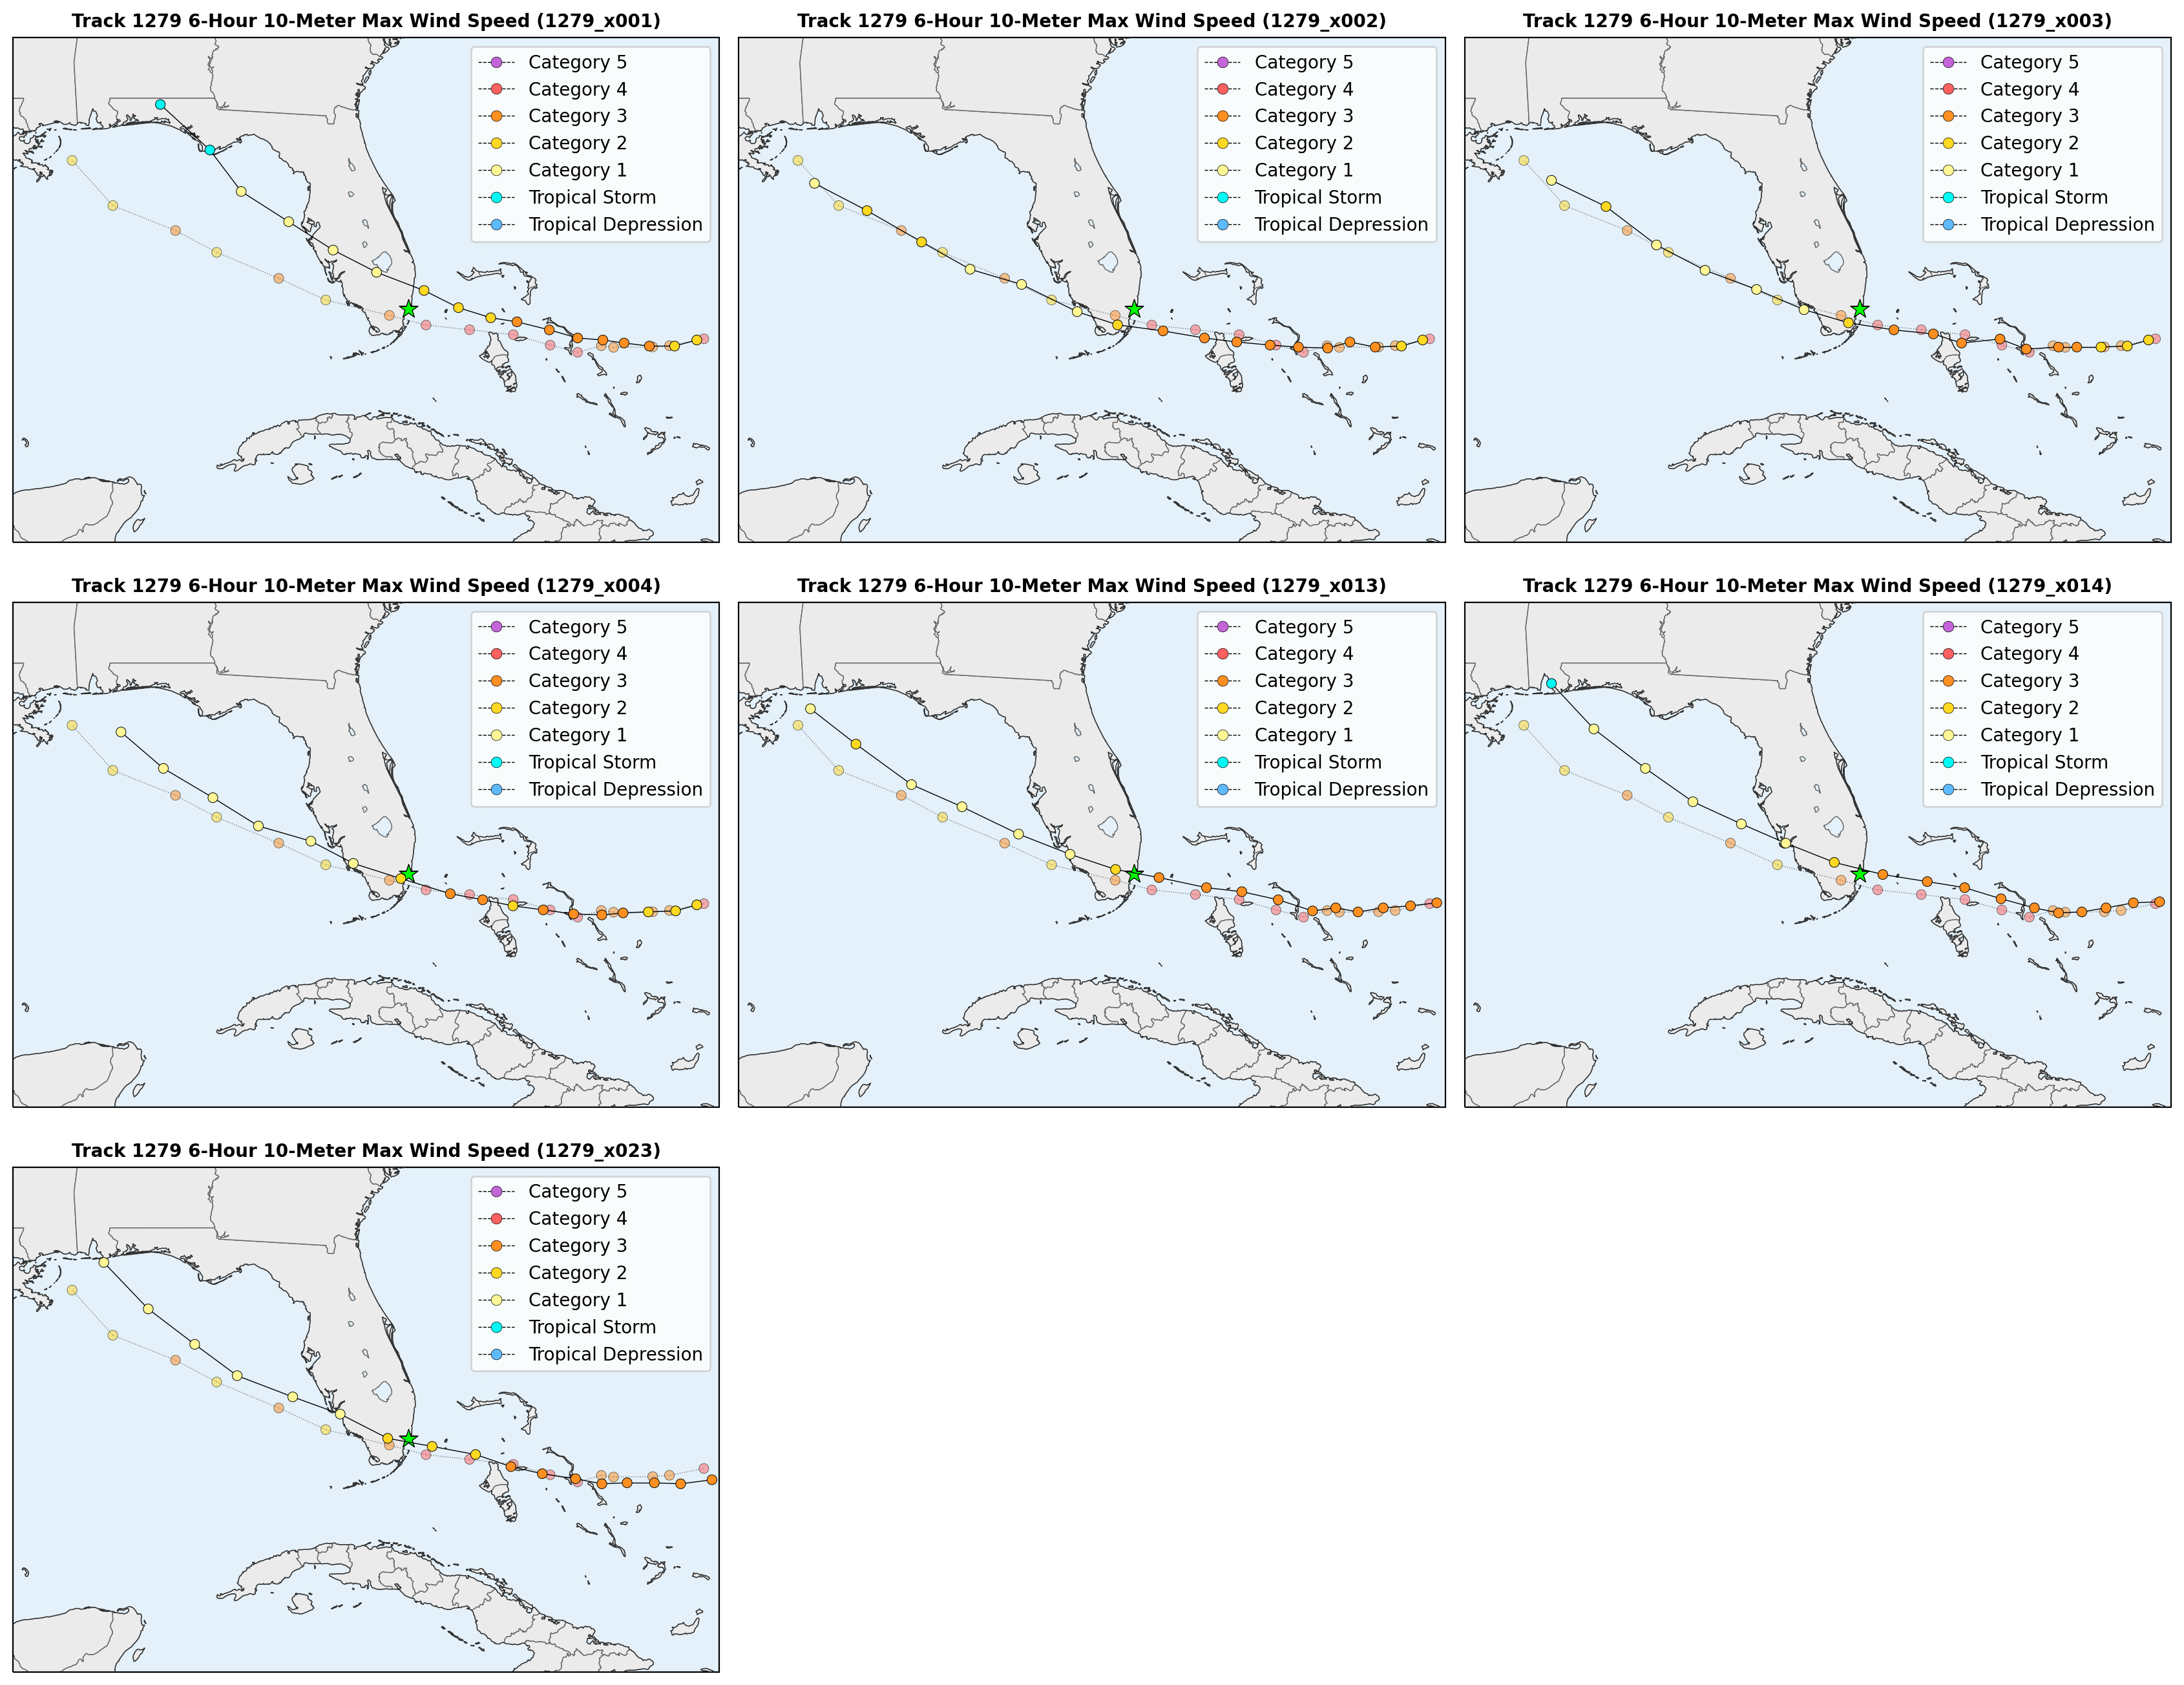

In [214]:
proj = ccrs.PlateCarree()
fig, axs = plt.subplots(3, 3, figsize=(17, 17), dpi=200, subplot_kw=dict(projection=proj))

#hours = 1
hours = 6
for i, ax in enumerate(axs.ravel()[:7]):
    geog_features(ax, 'florida')
    
    if hours == 1:
        wsp_data = max_wsps[i].values
        slp_data = min_slps[i].values
        lons = min_slps[i].lon.values
        lats = min_slps[i].lat.values
    elif hours == 6:
        wsp_data = max_wsps[i].sel(time=max_wsps[i].time.dt.hour.isin([0, 6, 12, 18])).values
        slp_data = min_slps[i].sel(time=min_slps[i].time.dt.hour.isin([0, 6, 12, 18])).values
        lons = min_slps[i].sel(time=min_slps[i].time.dt.hour.isin([0, 6, 12, 18])).lon.values
        lats = min_slps[i].sel(time=min_slps[i].time.dt.hour.isin([0, 6, 12, 18])).lat.values
    else:
        raise ValueError('Set hours to 1 or 6.')
        
    sshws_cmap = [sshws_color(wsp, units='m/s') for wsp in wsp_data]
    points = np.array([lons, lats]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(segments, colors='k', zorder=9, transform=proj, lw=0.5, ls='-')
    ax.add_collection(lc)
    ax.scatter(lons, lats, c=sshws_cmap, zorder=10, edgecolors='k', lw=0.35, s=30, transform=proj)
    
    if hours == 6:
        te_wsp = filtered_ot.wsp.values
        te_lons = filtered_ot.lon.values
        te_lats = filtered_ot.lat.values
        sshws_cmp = [sshws_color(wsp*0.85, units='m/s') for wsp in te_wsp]
        te_points = np.array([te_lons, te_lats]).T.reshape(-1, 1, 2)
        te_segments = np.concatenate([te_points[:-1], te_points[1:]], axis=1)
        lc = LineCollection(te_segments, colors='k', zorder=7, transform=proj, lw=0.5, ls=':', alpha=0.5)
        ax.add_collection(lc)
        ax.scatter(te_lons, te_lats, c=sshws_cmp, zorder=8, edgecolors='k', lw=0.35, s=30, transform=proj, alpha=0.5)
    
    miami_coords = (25.775163, -80.208615)
    ax.scatter(x=miami_coords[1]+360, y=miami_coords[0], zorder=6, marker='*', c='#00FF00', s=120, edgecolors='k', lw=0.5, transform=proj)
    
    # Marker properties
    mew = 0.25     # marker edge width
    mec = 'k'      # marker edge color
    ms = 6         # marker size
    #mfc           # marker face color

    td = mlines.Line2D([], [], marker='o', ms=ms, mew=mew, mec=mec, label='Tropical Depression', mfc=sshws_color(35, 'mph'), color='k', lw=0.5, ls='--')
    ts = mlines.Line2D([], [], marker='o', ms=ms, mew=mew, mec=mec, label='Tropical Storm', mfc=sshws_color(50, 'mph'), color='k', lw=0.5, ls='--')
    c1 = mlines.Line2D([], [], marker='o', ms=ms, mew=mew, mec=mec, label='Category 1', mfc=sshws_color(75, 'mph'), color='k', lw=0.5, ls='--')
    c2 = mlines.Line2D([], [], marker='o', ms=ms, mew=mew, mec=mec, label='Category 2', mfc=sshws_color(100, 'mph'), color='k', lw=0.5, ls='--')
    c3 = mlines.Line2D([], [], marker='o', ms=ms, mew=mew, mec=mec, label='Category 3', mfc=sshws_color(115, 'mph'), color='k', lw=0.5, ls='--')
    c4 = mlines.Line2D([], [], marker='o', ms=ms, mew=mew, mec=mec, label='Category 4', mfc=sshws_color(135, 'mph'), color='k', lw=0.5, ls='--')
    c5 = mlines.Line2D([], [], marker='o', ms=ms, mew=mew, mec=mec, label='Category 5', mfc=sshws_color(160, 'mph'), color='k', lw=0.5, ls='--')

    l = ax.legend(handles = [c5, c4, c3, c2, c1, ts, td], loc='upper right', 
                  fontsize=10, shadow=False)
    l.set_zorder(1001)
    if hours == 1:
        ax.set_title(f"Track 1279 Hourly 10-Meter Max Wind Speed ({tracks[i].split('/')[-1].split('.')[0]})", fontsize=10)
    elif hours != 1:
        ax.set_title(f"Track 1279 {hours}-Hour 10-Meter Max Wind Speed ({tracks[i].split('/')[-1].split('.')[0]})", fontsize=10)
        
fig.tight_layout(h_pad=-20.0)
fig.delaxes(axs[2][1])
fig.delaxes(axs[2][2])
fig.savefig('../figs/te_plots/track_1279_6hourly_wsp_tetrack.png', 
             facecolor='w', transparent=False, bbox_inches='tight')
plt.show()


In [ ]:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(12, 7), dpi=200, subplot_kw=dict(projection=proj))

geog_features(ax, 'florida')

wsp_6 = max_wsps[0].sel(time=max_wsps[0].time.dt.hour.isin([0, 6, 12, 18]))
slp_6 = min_slps[0].sel(time=min_slps[0].time.dt.hour.isin([0, 6, 12, 18]))
wsp_data = wsp_6.values
# wsp_data = max_wsps[0].values
# lons = min_slps[0].lon.values
# lats = min_slps[0].lat.values
lons = slp_6.lon.values
lats = slp_6.lat.values

sshws_cmap = [sshws_color(wsp, units='m/s') for wsp in wsp_data]
points = np.array([lons, lats]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

lc = LineCollection(segments, colors='k', zorder=9, transform=proj, lw=0.5, ls='--')
ax.add_collection(lc)
ax.scatter(lons, lats, c=sshws_cmap, zorder=10, edgecolors='k', lw=0.35, s=30)

miami_coords = (25.775163, -80.208615)
ax.scatter(x=miami_coords[1]+360, y=miami_coords[0], zorder=8, marker='*', c='#00FF00', s=120, edgecolors='k', lw=0.5, transform=proj)

# Marker properties
mew = 0.25     # marker edge width
mec = 'k'      # marker edge color
ms = 6         # marker size
#mfc           # marker face color

td = mlines.Line2D([], [], marker='o', ms=ms, mew=mew, mec=mec, label='Tropical Depression', mfc=sshws_color(35, 'mph'), color='k', lw=0.5, ls='--')
ts = mlines.Line2D([], [], marker='o', ms=ms, mew=mew, mec=mec, label='Tropical Storm', mfc=sshws_color(50, 'mph'), color='k', lw=0.5, ls='--')
c1 = mlines.Line2D([], [], marker='o', ms=ms, mew=mew, mec=mec, label='Category 1', mfc=sshws_color(75, 'mph'), color='k', lw=0.5, ls='--')
c2 = mlines.Line2D([], [], marker='o', ms=ms, mew=mew, mec=mec, label='Category 2', mfc=sshws_color(100, 'mph'), color='k', lw=0.5, ls='--')
c3 = mlines.Line2D([], [], marker='o', ms=ms, mew=mew, mec=mec, label='Category 3', mfc=sshws_color(115, 'mph'), color='k', lw=0.5, ls='--')
c4 = mlines.Line2D([], [], marker='o', ms=ms, mew=mew, mec=mec, label='Category 4', mfc=sshws_color(135, 'mph'), color='k', lw=0.5, ls='--')
c5 = mlines.Line2D([], [], marker='o', ms=ms, mew=mew, mec=mec, label='Category 5', mfc=sshws_color(160, 'mph'), color='k', lw=0.5, ls='--')

l = ax.legend(handles = [c5, c4, c3, c2, c1, ts, td], loc='upper right', 
              fontsize=10, shadow=False)
l.set_zorder(1001)
plt.title('Hourly 10-Meter Max Wind Speed (Track X)')
plt.show()

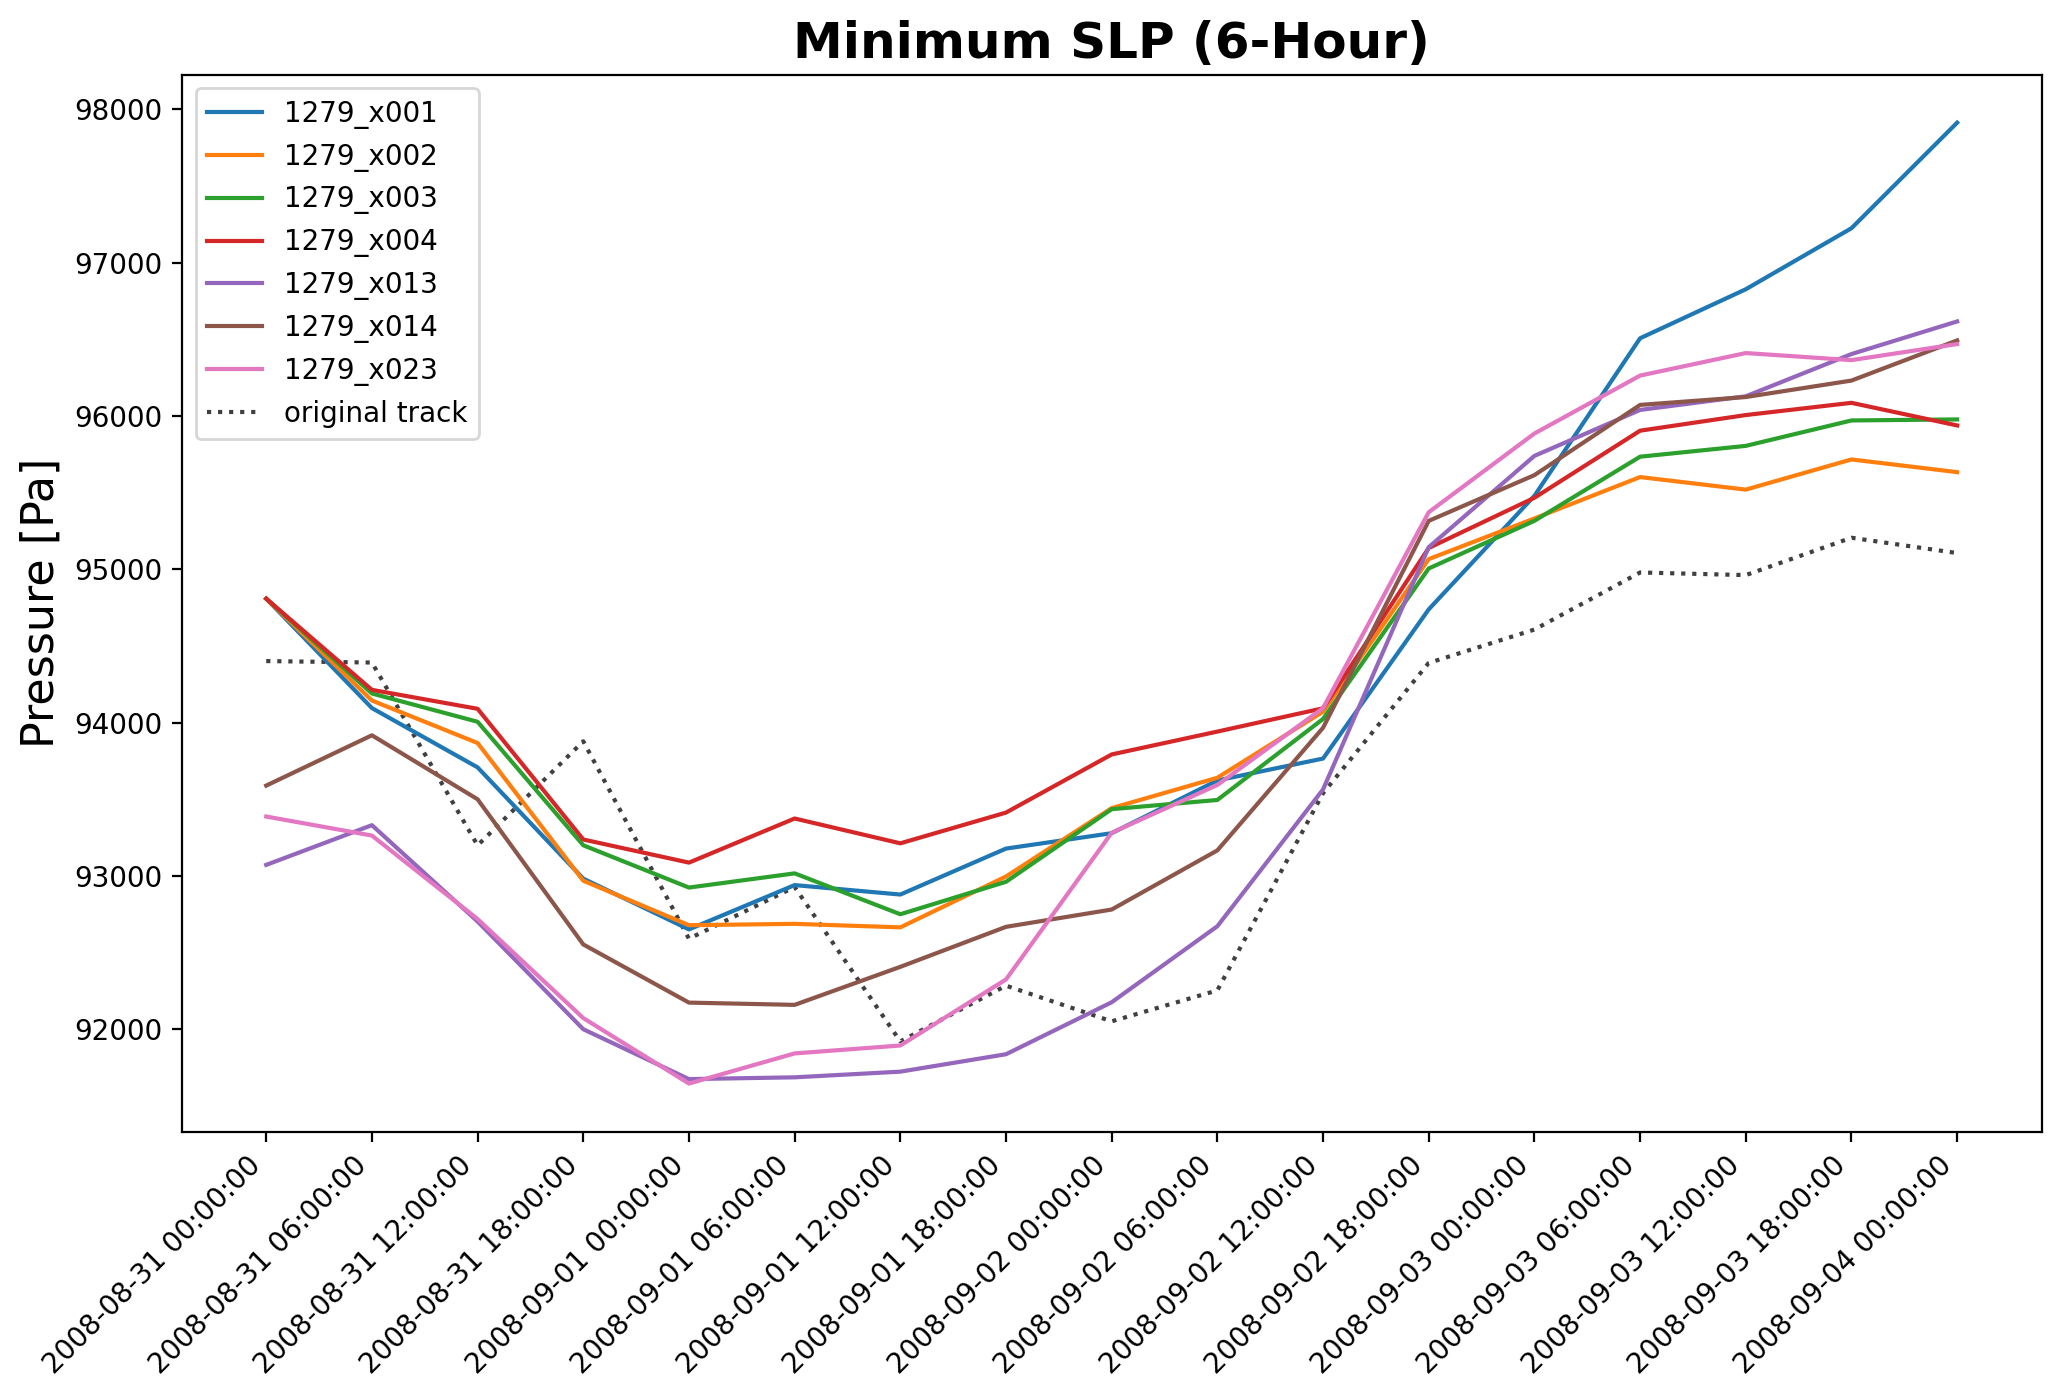

In [220]:
#hours = 1
hours = 6

fig, ax = plt.subplots(figsize=(12, 7), dpi=200)
for i, slp_sim in enumerate(min_slps):
    if hours == 1:
        times = slp_sim.time.dt.strftime("%Y-%m-%d %H:%M:%S").values
        slps = slp_sim.values
    elif hours == 6:
        times = slp_sim.sel(time=sim.time.dt.hour.isin([0, 6, 12, 18])).time.dt.strftime("%Y-%m-%d %H:%M:%S").values
        slps = slp_sim.sel(time=sim.time.dt.hour.isin([0, 6, 12, 18])).values
    ax.plot(times, slps, label=tracks[i].split('/')[-1].split('.')[0])
    
if hours == 1:
    ax.set_xticks(np.arange(0, len(times), 6))
elif hours == 6:
    ax.plot(filtered_ot.time.values, filtered_ot.slp.values, label='original track', color='k', zorder=1, ls=':', alpha=0.75)
ax.set_ylabel('Pressure [Pa]')
plt.setp(ax.get_xticklabels(), ha='right', rotation=45)
#ax.tick_params(axis='x', which='major', labelrotation=45)
#ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=45, ha='right')

if hours == 1:
    ax.set_title('Minimum SLP (Hourly)')
elif hours == 6:
    ax.set_title('Minimum SLP (6-Hour)')
ax.legend()
plt.show()
fig.savefig('../figs/te_plots/track_1279_6hourly_slp_tetrack.png', 
             facecolor='w', transparent=False, bbox_inches='tight')